In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
count = 0
for dirname, _, filenames in os.walk('/kaggle/input'):
    # for filename in filenames:
    # print(os.path.join(dirname, filename))
    if count == 1:
        print(filenames)
    count += 1

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

['bcn_20k_train.csv', 'bcn_20k_test.csv']


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

In [3]:
# Define paths
data_dir = '/kaggle/input/bcn20000'

# Training data directory and csv path
train_img_dir = os.path.join(data_dir, 'BCN_20k_train/bcn_20k_train')
train_metadata_path = os.path.join(data_dir, 'bcn_20k_train.csv')

# Testing data directory and csv path
test_img_dir = os.path.join(data_dir, 'BCN_20k_test/bcn_20k_test')
test_metadata_path = os.path.join(data_dir, 'bcn_20k_test.csv')

# Load metadata
metadata = pd.read_csv(train_metadata_path)
print(f"Total training images: {len(metadata)}")
print(f"Total testing images: {len(pd.read_csv(test_metadata_path))}")
metadata.head()

Total training images: 12413
Total testing images: 6533


,bcn_filename,age_approx,anatom_site_general,diagnosis,lesion_id,capture_date,sex,split
0,BCN_0000000001.jpg,55.0,anterior torso,MEL,BCN_0003884,2012-05-16,male,train
1,BCN_0000000003.jpg,50.0,anterior torso,MEL,BCN_0000019,2015-07-09,female,train
2,BCN_0000000004.jpg,85.0,head/neck,SCC,BCN_0003499,2015-11-23,male,train
3,BCN_0000000006.jpg,60.0,anterior torso,NV,BCN_0003316,2015-06-16,male,train
4,BCN_0000000010.jpg,30.0,anterior torso,BCC,BCN_0004874,2014-02-18,female,train


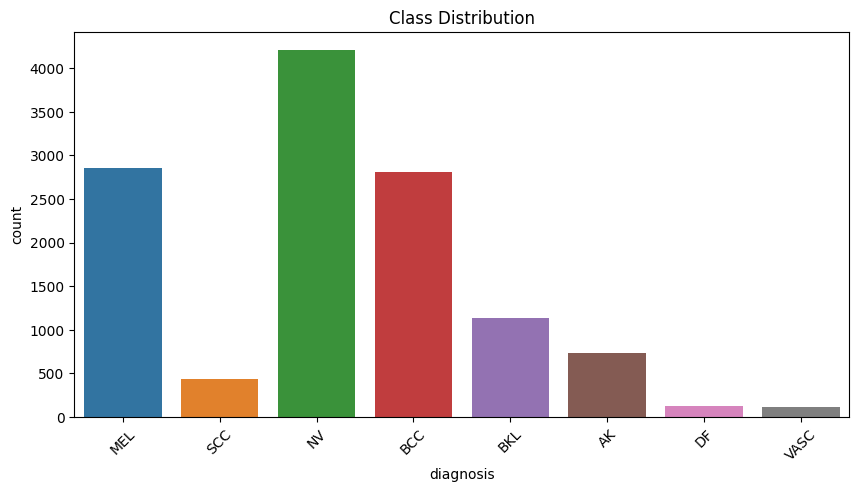

In [4]:
plt.figure(figsize=(10, 5))
sns.countplot(x='diagnosis', data=metadata)
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

In [5]:
# Define transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [6]:
class SkinLesionDataset(Dataset):
    def __init__(self, df, train_img_dir, transform=None):
        # Drop rows with missing 'diagnosis'
        self.df = df # df.dropna(subset=['diagnosis']).reset_index(drop=True)
        
        self.image_dir = train_img_dir
        self.transform = transform
        self.classes = sorted(self.df['diagnosis'].unique())
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['bcn_filename']
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        label = self.class_to_idx[self.df.iloc[idx]['diagnosis']]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [7]:
train_df, val_df = train_test_split(metadata, test_size=0.2, stratify=metadata['diagnosis'], random_state=42)

# Datasets
train_dataset = SkinLesionDataset(train_df, train_img_dir, transform=train_transforms)
val_dataset = SkinLesionDataset(val_df, train_img_dir, transform=val_transforms)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

In [8]:
# # Datasets
# metadata = metadata.dropna(subset=['diagnosis']).reset_index(drop=True)
# train_dataset = SkinLesionDataset(metadata, train_img_dir, transform=train_transforms)

# val_metadata = pd.read_csv(test_metadata_path)
# val_metadata = val_metadata.dropna(subset=['diagnosis']).reset_index(drop=True)
# val_dataset = SkinLesionDataset(val_metadata, test_img_dir, transform=val_transforms)


# # DataLoaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# print(f"Training size: {len(metadata)}")
# print(f"Testing size: {len(val_metadata)}")

In [9]:
# pd.read_csv(test_metadata_path).head()

In [10]:
# model = models.resnet18(pretrained=True)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))
# model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
from torchvision.models import efficientnet_b0

In [12]:
NUM_CLASSES = len(train_dataset.classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = efficientnet_b0(pretrained=True)

# Replace classifier head
model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 125MB/s] 


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [14]:
# def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
#     for epoch in range(epochs):
#         model.train()
#         running_loss = 0.0
#         for inputs, labels in train_loader:
#             inputs = inputs.to('cuda' if torch.cuda.is_available() else 'cpu')
#             labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')
            
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             running_loss += loss.item() * inputs.size(0)
        
#         epoch_loss = running_loss / len(train_loader.dataset)
#         print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')
    
#         # Saving the model checkpoint for current epoch
#         torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': epoch_loss  
#         }, f'/kaggle/working/effnet_checkpoint_epoch{epoch}.pth')
    
#         # Validation
#         model.eval()
#         correct = 0
#         total = 0
#         with torch.no_grad():
#             for inputs, labels in val_loader:
#                 inputs = inputs.to('cuda' if torch.cuda.is_available() else 'cpu')
#                 labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')
#                 outputs = model(inputs)
#                 _, preds = torch.max(outputs, 1)
#                 correct += (preds == labels).sum().item()
#                 total += labels.size(0)
            
#         print(correct, total)
#         val_acc = correct / total
#         print(f'Validation Accuracy: {val_acc:.4f}')

In [15]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_accuracies = []
    val_accuracies = []
    train_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs = inputs.to('cuda' if torch.cuda.is_available() else 'cpu')
            labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(train_acc)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_acc:.4f}')

        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss
        }, f'/kaggle/working/effnet_checkpoint_epoch{epoch}.pth')

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to('cuda' if torch.cuda.is_available() else 'cpu')
                labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total if val_total > 0 else 0
        val_accuracies.append(val_acc)
        print(f'Validation Accuracy: {val_acc:.4f}')

    return train_losses, train_accuracies, val_accuracies

In [16]:
train_losses, train_accuracies, val_accuracies, = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=25)

Epoch 1/25, Loss: 1.2169, Train Accuracy: 0.5748
Validation Accuracy: 0.6726
Epoch 2/25, Loss: 0.8996, Train Accuracy: 0.6750
Validation Accuracy: 0.7277
Epoch 3/25, Loss: 0.7744, Train Accuracy: 0.7238
Validation Accuracy: 0.7455
Epoch 4/25, Loss: 0.6733, Train Accuracy: 0.7574
Validation Accuracy: 0.7656
Epoch 5/25, Loss: 0.5877, Train Accuracy: 0.7867
Validation Accuracy: 0.7704
Epoch 6/25, Loss: 0.5114, Train Accuracy: 0.8132
Validation Accuracy: 0.8031
Epoch 7/25, Loss: 0.4462, Train Accuracy: 0.8388
Validation Accuracy: 0.8079
Epoch 8/25, Loss: 0.3908, Train Accuracy: 0.8616
Validation Accuracy: 0.8192
Epoch 9/25, Loss: 0.3405, Train Accuracy: 0.8831
Validation Accuracy: 0.8304
Epoch 10/25, Loss: 0.3046, Train Accuracy: 0.8928
Validation Accuracy: 0.8421
Epoch 11/25, Loss: 0.2620, Train Accuracy: 0.9050
Validation Accuracy: 0.8357
Epoch 12/25, Loss: 0.2383, Train Accuracy: 0.9190
Validation Accuracy: 0.8498
Epoch 13/25, Loss: 0.2034, Train Accuracy: 0.9278
Validation Accuracy: 0.

In [17]:

import matplotlib.pyplot as plt

# Assuming you collected accuracy history in these lists during training:
# train_accuracies = [...]
# val_accuracies = [...]

def plot_accuracy(train_accuracies, val_accuracies):
    epochs = range(1, len(train_accuracies) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

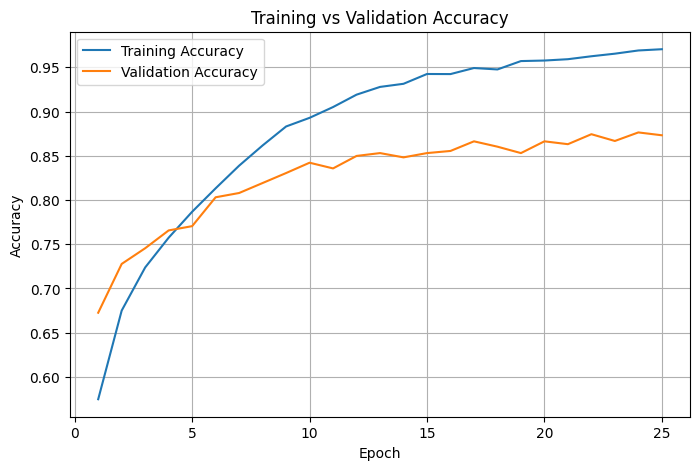

In [18]:
plot_accuracy(train_accuracies, val_accuracies)

In [19]:
import matplotlib.pyplot as plt

def plot_loss(train_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, label='Training Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.grid(True)
    plt.legend()
    plt.show()

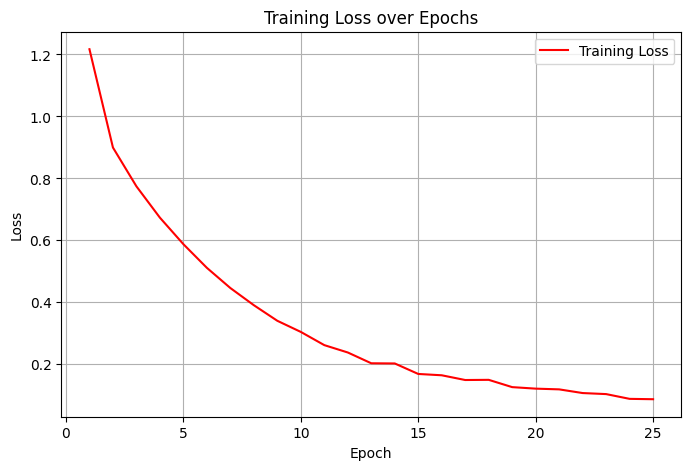

In [20]:
plot_loss(train_losses)

In [21]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to('cuda' if torch.cuda.is_available() else 'cpu')
        labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

              precision    recall  f1-score   support

          AK       0.70      0.82      0.76       147
         BCC       0.88      0.90      0.89       562
         BKL       0.84      0.69      0.76       228
          DF       1.00      0.72      0.84        25
         MEL       0.87      0.90      0.88       572
          NV       0.91      0.93      0.92       841
         SCC       0.91      0.69      0.78        86
        VASC       0.95      0.86      0.90        22

    accuracy                           0.87      2483
   macro avg       0.88      0.81      0.84      2483
weighted avg       0.87      0.87      0.87      2483



In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Example usage:
# plot_confusion_matrix(y_true, y_pred, class_names)

In [23]:
from sklearn.metrics import confusion_matrix

def compute_sens_spec(y_true, y_pred, class_names=None):
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)

    sensitivity = []
    specificity = []

    for i in range(len(cm)):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FN + FP)

        sens = TP / (TP + FN) if (TP + FN) > 0 else 0
        spec = TN / (TN + FP) if (TN + FP) > 0 else 0

        sensitivity.append(sens)
        specificity.append(spec)

    for i in range(len(cm)):
        label = class_names[i] if class_names else f"Class {i}"
        print(f"{label}: Sensitivity = {sensitivity[i]:.4f}, Specificity = {specificity[i]:.4f}")

# Example usage:
# compute_sens_spec(y_true, y_pred, class_names)

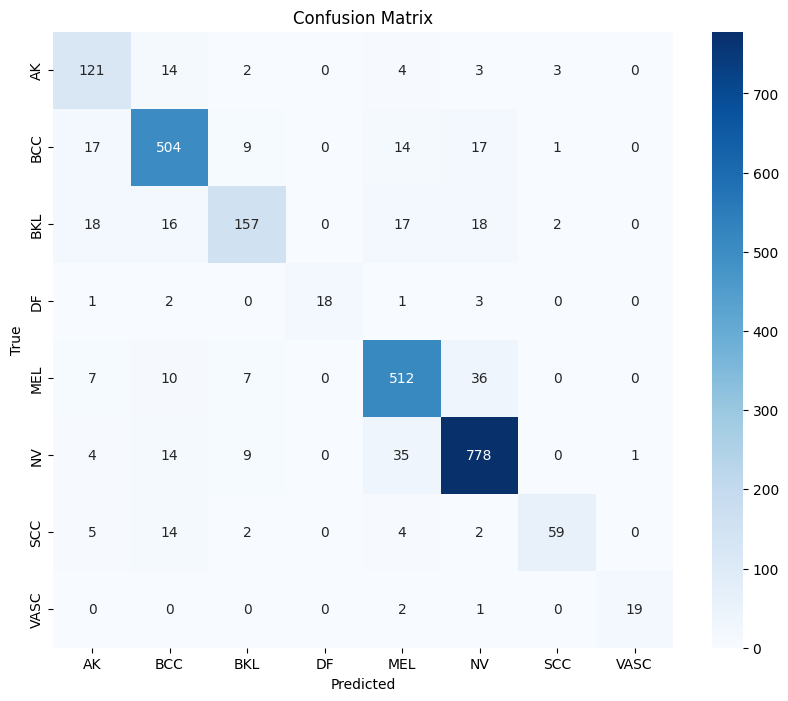

Confusion Matrix:
 [[121  14   2   0   4   3   3   0]
 [ 17 504   9   0  14  17   1   0]
 [ 18  16 157   0  17  18   2   0]
 [  1   2   0  18   1   3   0   0]
 [  7  10   7   0 512  36   0   0]
 [  4  14   9   0  35 778   0   1]
 [  5  14   2   0   4   2  59   0]
 [  0   0   0   0   2   1   0  19]]
AK: Sensitivity = 0.8231, Specificity = 0.9777
BCC: Sensitivity = 0.8968, Specificity = 0.9636
BKL: Sensitivity = 0.6886, Specificity = 0.9871
DF: Sensitivity = 0.7200, Specificity = 1.0000
MEL: Sensitivity = 0.8951, Specificity = 0.9597
NV: Sensitivity = 0.9251, Specificity = 0.9513
SCC: Sensitivity = 0.6860, Specificity = 0.9975
VASC: Sensitivity = 0.8636, Specificity = 0.9996


In [24]:
# Confusion Matrix
plot_confusion_matrix(all_labels, all_preds, class_names=train_dataset.classes)

# Sensitivity & Specificity
compute_sens_spec(all_labels, all_preds, class_names=train_dataset.classes)

### Model without data augmentation

In [25]:
train_df, val_df = train_test_split(metadata, test_size=0.2, stratify=metadata['diagnosis'], random_state=42)

# Datasets
train_dataset = SkinLesionDataset(train_df, train_img_dir, transform=val_transforms)
val_dataset = SkinLesionDataset(val_df, train_img_dir, transform=val_transforms)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

In [26]:
model_2 = efficientnet_b0(pretrained=True)

# Replace classifier head
model_2.classifier[1] = nn.Linear(model_2.classifier[1].in_features, NUM_CLASSES)
model_2 = model_2.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [28]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_accuracies = []
    val_accuracies = []
    train_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs = inputs.to('cuda' if torch.cuda.is_available() else 'cpu')
            labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(train_acc)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Train Accuracy: {train_acc:.4f}')

        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss
        }, f'/kaggle/working/effnet_no_aug_checkpoint_epoch{epoch}.pth')

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to('cuda' if torch.cuda.is_available() else 'cpu')
                labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total if val_total > 0 else 0
        val_accuracies.append(val_acc)
        print(f'Validation Accuracy: {val_acc:.4f}')

    return train_losses, train_accuracies, val_accuracies

In [29]:
train_losses, train_accuracies, val_accuracies = train_model(model_2, train_loader, val_loader, criterion, optimizer, epochs=25)

Epoch 1/25, Loss: 2.0716, Train Accuracy: 0.1489
Validation Accuracy: 0.1389
Epoch 2/25, Loss: 2.0739, Train Accuracy: 0.1456
Validation Accuracy: 0.1341
Epoch 3/25, Loss: 2.0743, Train Accuracy: 0.1458
Validation Accuracy: 0.1373
Epoch 4/25, Loss: 2.0731, Train Accuracy: 0.1559
Validation Accuracy: 0.1333
Epoch 5/25, Loss: 2.0755, Train Accuracy: 0.1423
Validation Accuracy: 0.1337
Epoch 6/25, Loss: 2.0740, Train Accuracy: 0.1463
Validation Accuracy: 0.1273
Epoch 7/25, Loss: 2.0743, Train Accuracy: 0.1462
Validation Accuracy: 0.1317
Epoch 8/25, Loss: 2.0768, Train Accuracy: 0.1443
Validation Accuracy: 0.1385
Epoch 9/25, Loss: 2.0743, Train Accuracy: 0.1446
Validation Accuracy: 0.1389
Epoch 10/25, Loss: 2.0727, Train Accuracy: 0.1457
Validation Accuracy: 0.1289
Epoch 11/25, Loss: 2.0743, Train Accuracy: 0.1491
Validation Accuracy: 0.1321
Epoch 12/25, Loss: 2.0752, Train Accuracy: 0.1404
Validation Accuracy: 0.1410
Epoch 13/25, Loss: 2.0749, Train Accuracy: 0.1424
Validation Accuracy: 0.

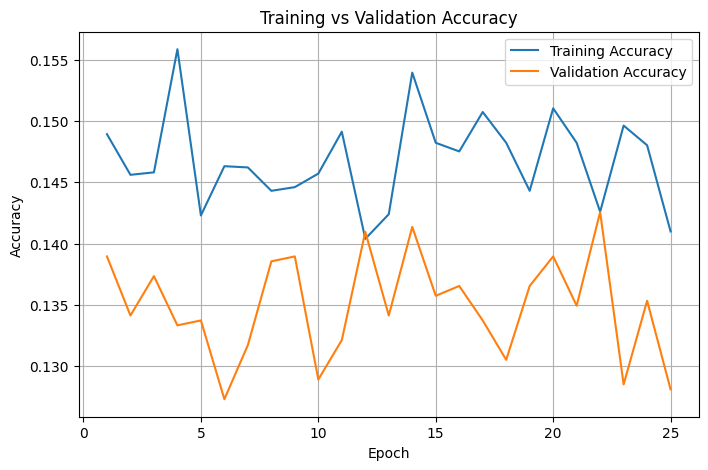

In [30]:
plot_accuracy(train_accuracies, val_accuracies)

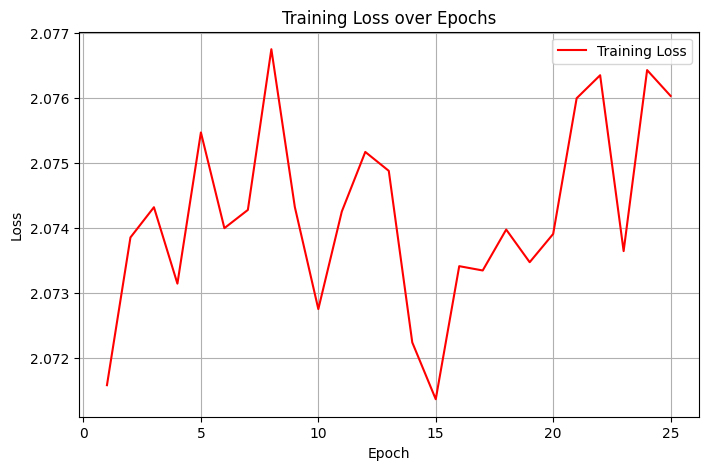

In [31]:
plot_loss(train_losses)

In [32]:
model_2.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to('cuda' if torch.cuda.is_available() else 'cpu')
        labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')
        outputs = model_2(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

              precision    recall  f1-score   support

          AK       0.05      0.05      0.05       147
         BCC       0.22      0.06      0.09       562
         BKL       0.09      0.07      0.08       228
          DF       0.01      0.12      0.02        25
         MEL       0.18      0.15      0.16       572
          NV       0.36      0.18      0.24       841
         SCC       0.03      0.29      0.06        86
        VASC       0.00      0.00      0.00        22

    accuracy                           0.13      2483
   macro avg       0.12      0.11      0.09      2483
weighted avg       0.23      0.13      0.15      2483



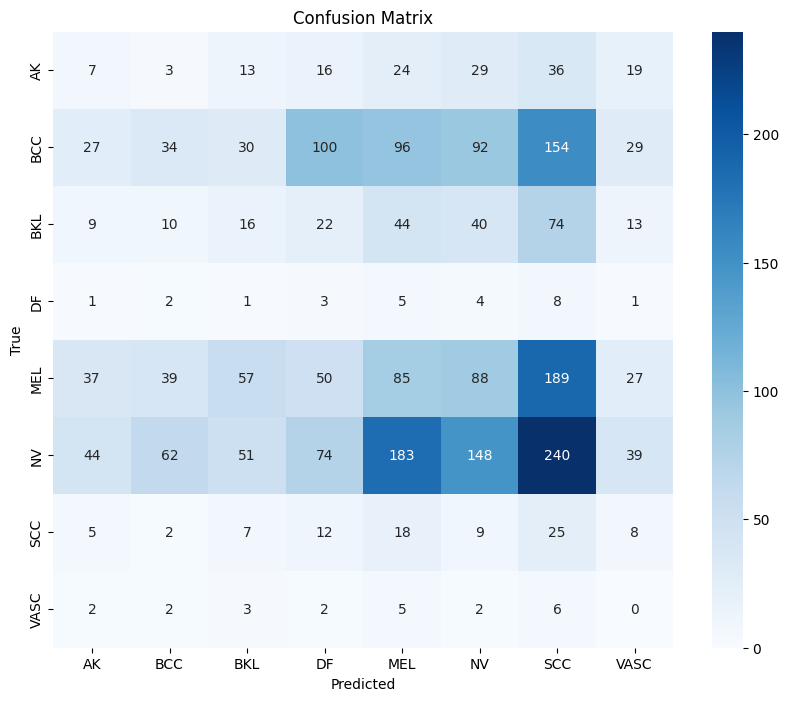

Confusion Matrix:
 [[  7   3  13  16  24  29  36  19]
 [ 27  34  30 100  96  92 154  29]
 [  9  10  16  22  44  40  74  13]
 [  1   2   1   3   5   4   8   1]
 [ 37  39  57  50  85  88 189  27]
 [ 44  62  51  74 183 148 240  39]
 [  5   2   7  12  18   9  25   8]
 [  2   2   3   2   5   2   6   0]]
AK: Sensitivity = 0.0476, Specificity = 0.9465
BCC: Sensitivity = 0.0605, Specificity = 0.9375
BKL: Sensitivity = 0.0702, Specificity = 0.9282
DF: Sensitivity = 0.1200, Specificity = 0.8877
MEL: Sensitivity = 0.1486, Specificity = 0.8038
NV: Sensitivity = 0.1760, Specificity = 0.8392
SCC: Sensitivity = 0.2907, Specificity = 0.7050
VASC: Sensitivity = 0.0000, Specificity = 0.9447


In [33]:
# Confusion Matrix
plot_confusion_matrix(all_labels, all_preds, class_names=train_dataset.classes)

# Sensitivity & Specificity
compute_sens_spec(all_labels, all_preds, class_names=train_dataset.classes)

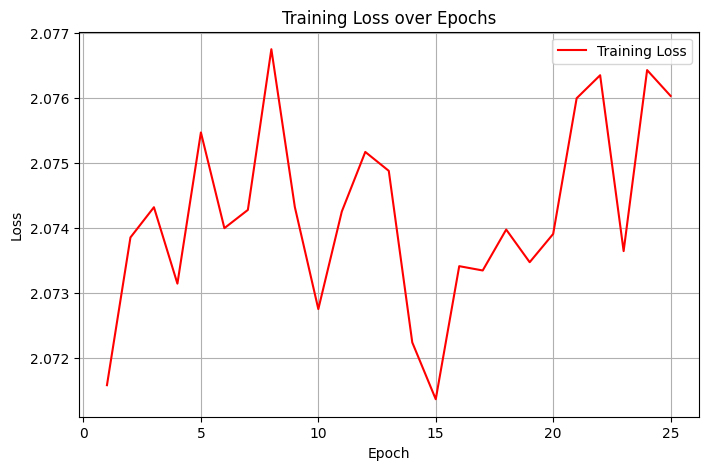

In [34]:
plot_loss(train_losses)